In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from copy import deepcopy

from typing import List, Tuple, Dict

# Read Data

In [2]:
dataset = pd.read_excel("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/heatpumps/NEEP_Database.xlsx")


In [3]:
dataset["Ducting Configuration"].value_counts()

Ducting Configuration
Singlezone Ducted, Centrally Ducted         33648
Singlezone Non-Ducted, Wall Placement        2213
Multizone All Non-Ducted                      974
Singlezone Ducted, Compact Ducted             818
Singlezone Non-Ducted, Ceiling Placement      702
Multizone All Ducted                          589
Multizone Mix of Non-Ducted and Ducted        538
Singlezone Non-Ducted, Floor Placement        242
Name: count, dtype: int64

In [4]:
len(dataset)

39726

# Transform Data

In [5]:
dataset = dataset.drop_duplicates()

In [6]:
def get_columns(temp: int) -> List[str]:
    if temp in [17, 47]:
        cols_to_include = [
            "SEER", 
            f"COP at Min. Capacit {temp}°F", 
            f"COP at Rated Capacity {temp}°F", 
            f"COP at Max. Capacity {temp}°F", 
            f"Minimum Capacity {temp}°F", 
            f"Rated Capacity {temp}°F", 
            f"Maximum Capacity {temp}°F",
        ]
    else:
        cols_to_include = [
            "SEER", 
            f"COP at Min. Capacity {temp}°F", 
            f"COP at Rated Capacity {temp}°F", 
            f"COP at Max. Capacity {temp}°F", 
            f"Minimum Capacity {temp}°F", 
            f"Rated Capacity {temp}°F", 
            f"Maximum Capacity {temp}°F",
        ]

    return cols_to_include

In [7]:
def celsius_a_fahrenheit(celsius: int) -> int:
    match celsius:
        case -8:
            return 17
        case 8:
            return 47
        case 28:
            return 82
        case 35:
            return 95
        case _:
            return int(celsius * 9/5 + 32)

def fahrenheit_a_celsius(fahrenheit: int) -> int:
    match fahrenheit:
        case 17:
            return -8
        case 47:
            return 8
        case 82:
            return 28
        case 95:
            return 35
        case _:
            return int((fahrenheit - 32) * 5/9)

In [8]:
dataset_singlezone = dataset.where(dataset["Ducting Configuration"].isin([
    "Singlezone Ducted, Centrally Ducted", 
    "Singlezone Non-Ducted, Wall Placement", 
    "Singlezone Ducted, Compact Ducted", 
    "Singlezone Non-Ducted, Ceiling Placement", 
    "Singlezone Non-Ducted, Floor Placement",
]))

dataset_multizone = dataset.where(dataset["Ducting Configuration"].isin([
    "Multizone All Non-Ducted", 
    "Multizone All Ducted", 
    "Multizone Mix of Non-Ducted and Ducted",
]))


In [9]:
data_8_bajocero_singlezone = dataset_singlezone[get_columns(celsius_a_fahrenheit(-8))].dropna()
data_8_bajocero_multizone = dataset_multizone[get_columns(celsius_a_fahrenheit(-8))].dropna()

data_8_singlezone = dataset_singlezone[get_columns(celsius_a_fahrenheit(8))].dropna()
data_8_multizone = dataset_multizone[get_columns(celsius_a_fahrenheit(8))].dropna()

data_28_singlezone = dataset_singlezone[get_columns(celsius_a_fahrenheit(28))].dropna()
data_28_multizone = dataset_multizone[get_columns(celsius_a_fahrenheit(28))].dropna()

data_35_singlezone = dataset_singlezone[get_columns(celsius_a_fahrenheit(35))].dropna()
data_35_multizone = dataset_multizone[get_columns(celsius_a_fahrenheit(35))].dropna()

In [10]:
data_8_singlezone.head()

,SEER,COP at Min. Capacit 47°F,COP at Rated Capacity 47°F,COP at Max. Capacity 47°F,Minimum Capacity 47°F,Rated Capacity 47°F,Maximum Capacity 47°F
0,22.0,3.57,3.38,3.58,1950.0,12000.0,14910.0
2,18.0,3.71,3.18,2.01,10500.0,34600.0,37000.0
3,17.3,3.61,2.58,2.52,13800.0,44000.0,62000.0
4,19.0,4.48,3.02,2.71,13000.0,34600.0,50000.0
5,18.0,3.05,3.12,1.90,7500.0,26000.0,35000.0


# Models

In [11]:
models = {
    "kmeans_-8": {"singlezone": None, "multizone": None},
    "kmeans_8": {"singlezone": None, "multizone": None},
    "kmeans_28": {"singlezone": None, "multizone": None},
    "kmeans_35": {"singlezone": None, "multizone": None},
}

# Select columns to cluster
train_data = {
    "kmeans_-8": {"singlezone": data_8_bajocero_singlezone, "multizone": data_8_bajocero_multizone},
    "kmeans_8": {"singlezone": data_8_singlezone, "multizone": data_8_multizone},
    "kmeans_28": {"singlezone": data_28_singlezone, "multizone": data_28_multizone},
    "kmeans_35": {"singlezone": data_35_singlezone, "multizone": data_35_multizone},
}

inertias = {
    "kmeans_-8": {"singlezone": [], "multizone": []},
    "kmeans_8": {"singlezone": [], "multizone": []},
    "kmeans_28": {"singlezone": [], "multizone": []},
    "kmeans_35": {"singlezone": [], "multizone": []},
}

In [12]:
def model_name_to_temp(model_name: str) -> int:
    match model_name:
        case "kmeans_-8":
            return -8
        case "kmeans_8":
            return 8
        case "kmeans_28":
            return 28
        case "kmeans_35":
            return 35

In [13]:
for model_name in models:
    data_s = train_data[model_name]["singlezone"]
    data_m = train_data[model_name]["multizone"]
    temp = celsius_a_fahrenheit(model_name_to_temp(model_name))

    # Convert btu into kwh, only on last 3 columns
    for col in data_s.columns[-3:]:
        data_s[col] = data_s[col] * 0.000293071071
    for col in data_m.columns[-3:]:
        data_m[col] = data_m[col] * 0.000293071071


In [14]:
# Fit models
for i in range(1, 11):
    for model_name in models:
        for zone in models[model_name]:
            models[model_name][zone] = KMeans(n_clusters=i)
            models[model_name][zone].fit(train_data[model_name][zone])
            inertias[model_name][zone].append(models[model_name][zone].inertia_)

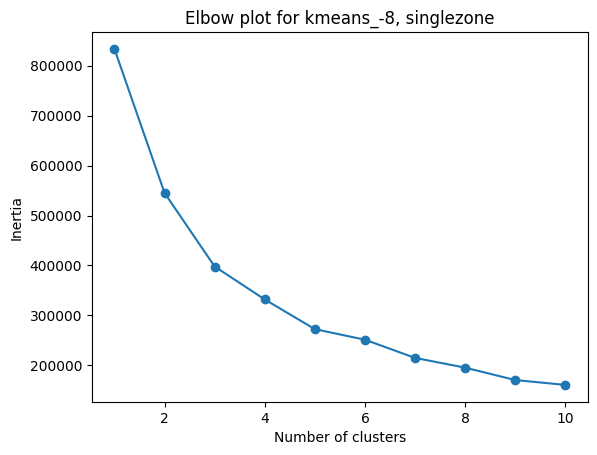

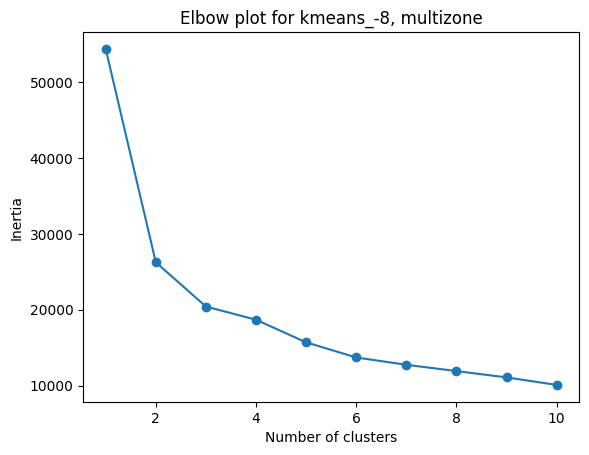

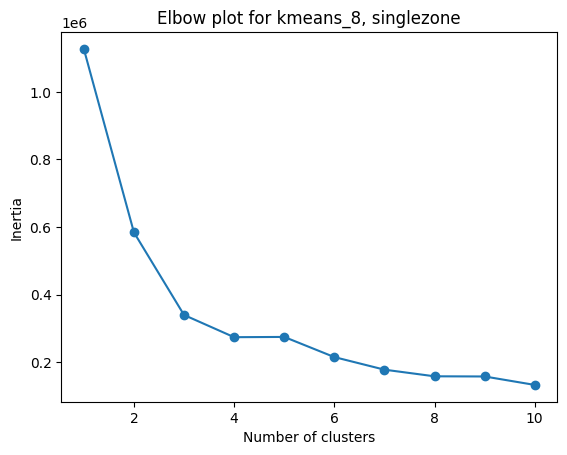

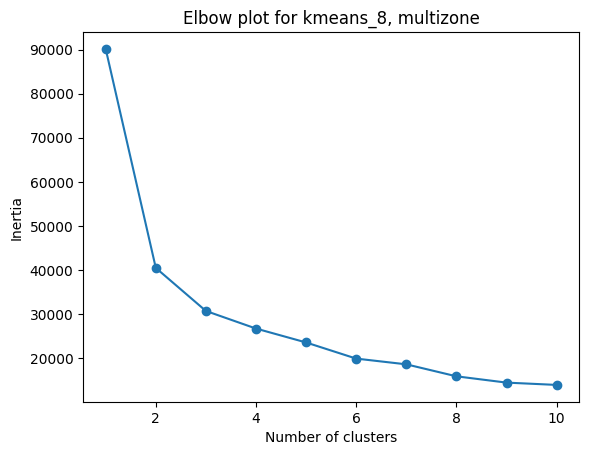

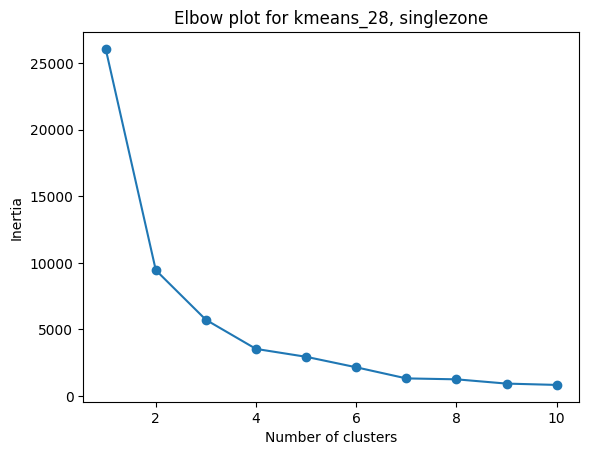

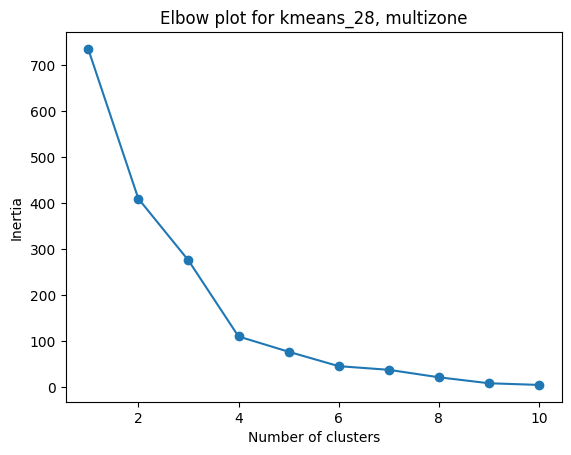

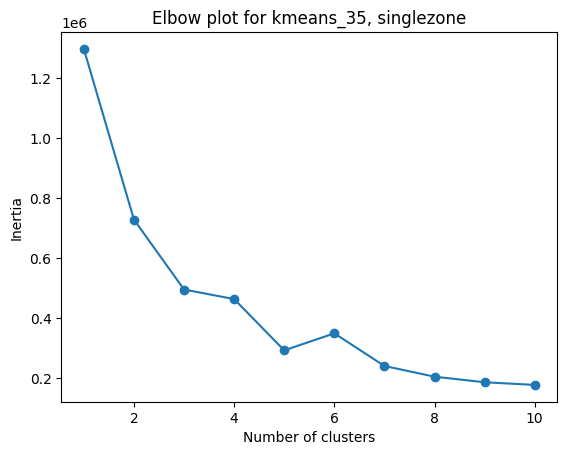

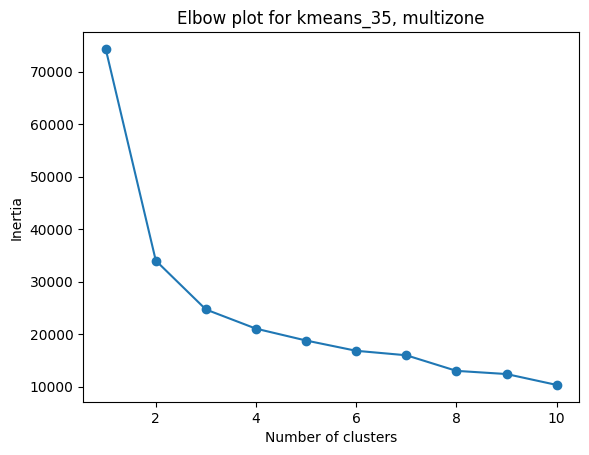

In [15]:
# Elbow plot for each model
for model_name in models:
    for zone in models[model_name]:
        plt.plot(range(1, 11), inertias[model_name][zone], marker='o')
        plt.title(f"Elbow plot for {model_name}, {zone}")
        plt.xlabel("Number of clusters")
        plt.ylabel("Inertia")
        plt.show()

# Training

In [16]:
# Train model with 5 clusters
n_clusters = 5
for model_name in models:
    for zone in models[model_name]:
        models[model_name][zone] = KMeans(n_clusters=n_clusters)
        models[model_name][zone].fit(train_data[model_name][zone])

# Results

In [17]:
def get_medoids(model: KMeans, data: pd.DataFrame) -> List[int]:
    medoids = []
    for i in range(n_clusters):
        cluster_data = data[model.labels_ == i]
        distances = np.linalg.norm(cluster_data - model.cluster_centers_[i], axis=1)
        medoid_index = np.argmin(distances)
        medoids.append(cluster_data.iloc[medoid_index])
    return medoids

In [18]:
get_medoids(models["kmeans_-8"]["singlezone"], data_8_bajocero_singlezone)

[SEER                          18.500000
 COP at Min. Capacit 17°F       3.180000
 COP at Rated Capacity 17°F     4.250000
 COP at Max. Capacity 17°F      2.620000
 Minimum Capacity 17°F          7.953949
 Rated Capacity 17°F           11.136701
 Maximum Capacity 17°F         11.341850
 Name: 32428, dtype: float64,
 SEER                          17.000000
 COP at Min. Capacit 17°F       2.630000
 COP at Rated Capacity 17°F     2.620000
 COP at Max. Capacity 17°F      2.620000
 Minimum Capacity 17°F          1.604564
 Rated Capacity 17°F            5.597657
 Maximum Capacity 17°F          5.954032
 Name: 33564, dtype: float64,
 SEER                          22.000000
 COP at Min. Capacit 17°F       2.760000
 COP at Rated Capacity 17°F     2.530000
 COP at Max. Capacity 17°F      2.310000
 Minimum Capacity 17°F          1.488801
 Rated Capacity 17°F            3.370317
 Maximum Capacity 17°F          4.325729
 Name: 9446, dtype: float64,
 SEER                          18.000000
 COP at M

In [19]:
# Compute average distance to medoid
def average_distance_to_medoid(model: KMeans, data: pd.DataFrame) -> float:
    medoids = get_medoids(model, data)
    distances = []
    for i in range(n_clusters):
        cluster_data = data[model.labels_ == i]
        distances.extend(np.linalg.norm(cluster_data - medoids[i], axis=1))
    return np.mean(distances)

# Compute max distance to medoid
def max_distance_to_medoid(model: KMeans, data: pd.DataFrame) -> float:
    medoids = get_medoids(model, data)
    distances = []
    for i in range(n_clusters):
        cluster_data = data[model.labels_ == i]
        distances.extend(np.linalg.norm(cluster_data - medoids[i], axis=1))
    return np.max(distances)

In [20]:
for model_name in models:
    for zone in models[model_name]:
        print(f"{model_name}, {zone}:")
        print(f"\tAverage distance to center: {average_distance_to_medoid(models[model_name][zone], train_data[model_name][zone]):.2f}")
        print(f"\tMax distance to center: {max_distance_to_medoid(models[model_name][zone], train_data[model_name][zone]):.2f}")

kmeans_-8, singlezone:
	Average distance to center: 2.64
	Max distance to center: 25.95
kmeans_-8, multizone:
	Average distance to center: 2.67
	Max distance to center: 12.11
kmeans_8, singlezone:
	Average distance to center: 2.19
	Max distance to center: 18.54
kmeans_8, multizone:
	Average distance to center: 2.93
	Max distance to center: 30.94
kmeans_28, singlezone:
	Average distance to center: 1.54
	Max distance to center: 8.40
kmeans_28, multizone:
	Average distance to center: 1.18
	Max distance to center: 6.10
kmeans_35, singlezone:
	Average distance to center: 2.25
	Max distance to center: 79.65
kmeans_35, multizone:
	Average distance to center: 2.60
	Max distance to center: 51.31


In [21]:
# Find medoid datapoints in the original dataset
def get_medoids_in_dataset(model: KMeans, data: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    medoids = get_medoids(model, data)
    medoids_df = pd.DataFrame(medoids, columns=data.columns)

    dataset_with_medoids = dataset[dataset.index.isin(medoids_df.index)]
    return dataset_with_medoids

In [22]:
get_medoids_in_dataset(models["kmeans_-8"]["multizone"], data_8_bajocero_multizone, dataset)["Ducting Configuration"]

2648                   Multizone All Non-Ducted
9933     Multizone Mix of Non-Ducted and Ducted
11275    Multizone Mix of Non-Ducted and Ducted
28235                      Multizone All Ducted
39075    Multizone Mix of Non-Ducted and Ducted
Name: Ducting Configuration, dtype: object

In [23]:
medoids = {
    "kmeans_-8": {"singlezone": None, "multizone": None},
    "kmeans_8": {"singlezone": None, "multizone": None},
    "kmeans_28": {"singlezone": None, "multizone": None},
    "kmeans_35": {"singlezone": None, "multizone": None},
}

for model_name in models:
    for zone in models[model_name]:
        medoids[model_name][zone] = get_medoids_in_dataset(models[model_name][zone], train_data[model_name][zone], dataset)

In [24]:
medoids["kmeans_35"]["multizone"]

,Status,Brand Name,Series Name,AHRI Certified Reference No.,Old AHRI Certified Reference No.,AHRI Type,Outdoor Unit Model,Indoor Unit Type,Indoor Model(s),Furnace Model Number (if applicable),...,Rated Input Power 82°F,Input Power at Max. Capacity 82°F,COP at Min. Capacity 82°F,COP at Rated Capacity 82°F,COP at Max. Capacity 82°F,Optional Low Temperature Data Outdoor Dry Bulb (°F),Optional Low Temperature Data Minimum Capacity X°F,Optional Low Temperature Data Maximum Capacity X°F,Optional Low Temperature Data Input Power at Min. Capacity X°F,Optional Low Temperature Data Input Power at Max. Capacity X°F
5974,Live,AC PRO.COM,NaN,NaN,210343322,HMSV-A-CB,A5OA-55HFN1-M,Mixed Ducted and Non-Ducted Indoor Units,NaN,NaN,...,NaN,5.02,5.35,NaN,2.85,-13.0,9300.0,30000.0,2.1,5.19
6003,Live,MRCOOL,NaN,NaN,208552972,HMSV-A-CB,DIY-MULTI5-48HP230C,Non-Ducted Indoor Units,NaN,NaN,...,NaN,4.05,5.27,NaN,3.69,NaN,NaN,NaN,NaN,NaN
9714,Live,SEA BREEZE+,NaN,NaN,208128299,HMSV-A-CB,HMZ36H424ZMO,Mixed Ducted and Non-Ducted Indoor Units,NaN,NaN,...,NaN,3.98,6.34,NaN,3.35,NaN,NaN,NaN,NaN,NaN
11029,Live,LENNOX,NaN,NaN,207768732,HMSV-A-CB,MLB030S4M-1P,Mixed Ducted and Non-Ducted Indoor Units,NaN,NaN,...,NaN,2.15,6.29,NaN,4.16,NaN,NaN,NaN,NaN,NaN
14419,Live,Haier,NaN,NaN,207698996,HMSR-A-CB-O,2U18MS2HD**,NaN,"AW09TC2HD**, AW09TC2HD**",NaN,...,NaN,1.24,6.19,NaN,4.49,-4.0,2000.0,11400.0,0.3,1.91


# Plots

In [25]:
# Perform PCA to plot data in 2D
def pca_plot(data: pd.DataFrame, model: KMeans, zone: str) -> None:
    pca = PCA(n_components=2)
    pca.fit(data)
    data_pca = pca.transform(data)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(data_pca[:, 0], data_pca[:, 1], c=model.labels_, cmap='viridis', s=50, alpha=0.5)
    # Plot medoids in red
    medoids = get_medoids(model, data)
    medoids = np.array(medoids)
    medoids_pca = pca.transform(medoids)
    ax.scatter(medoids_pca[:, 0], medoids_pca[:, 1], c='red', s=200, marker='x')

    # Display axis titles 
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    plt.title(f"Clustering {model_name}, {zone}")

    plt.show()

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


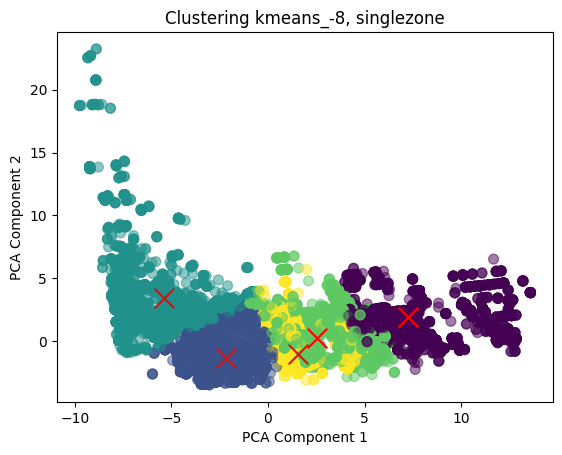

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


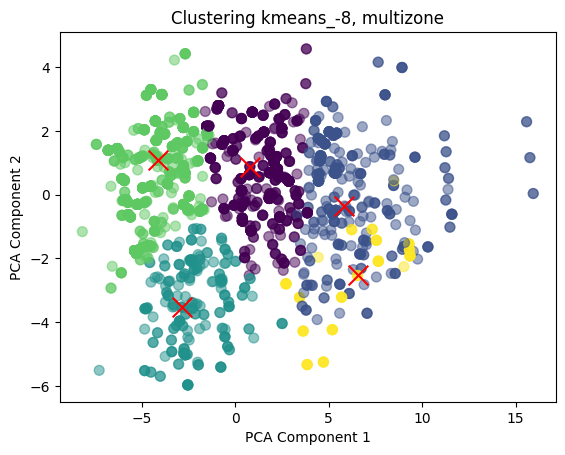

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


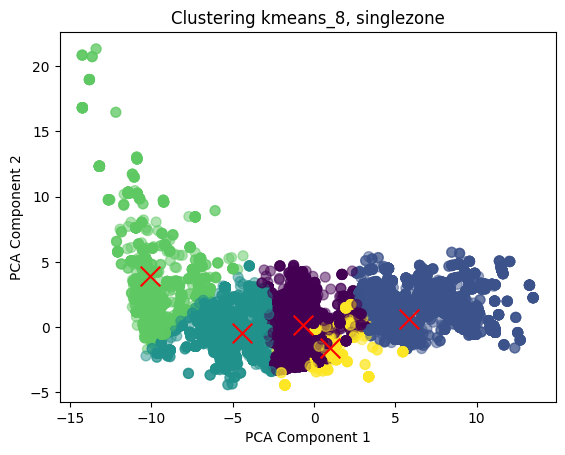

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


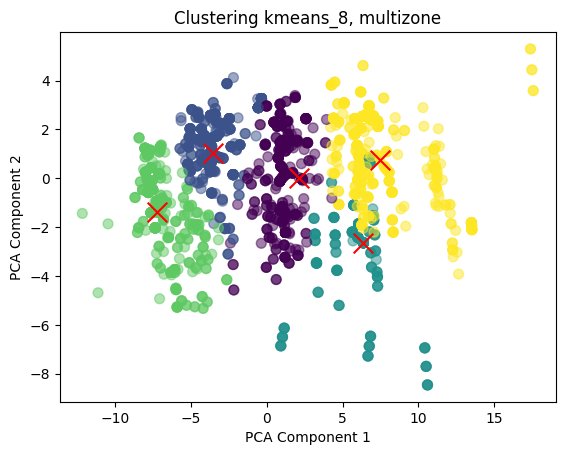

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


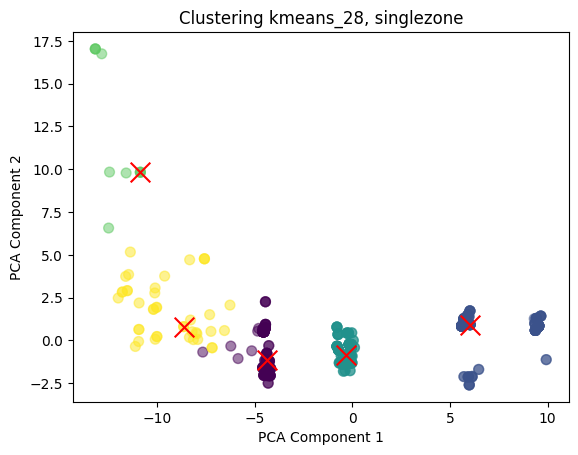

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


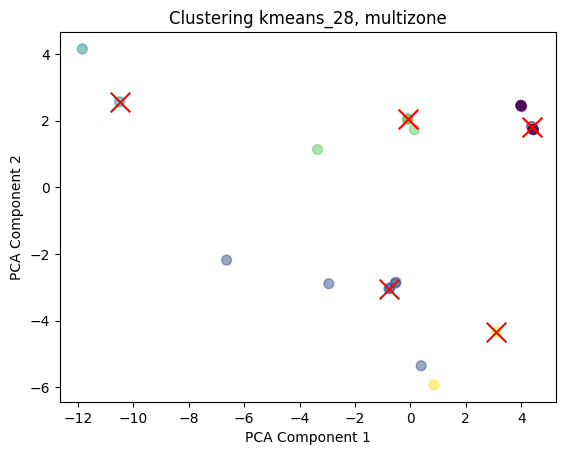

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


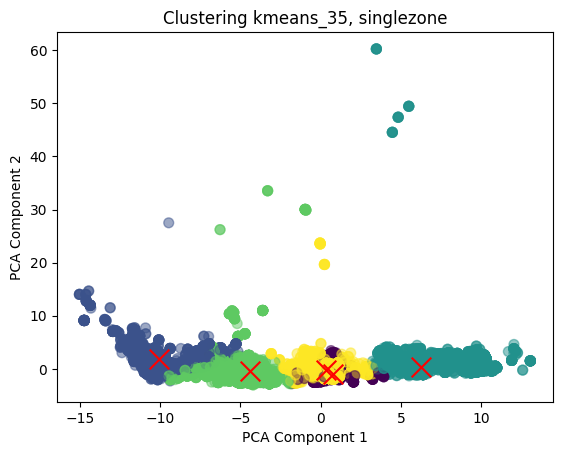

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


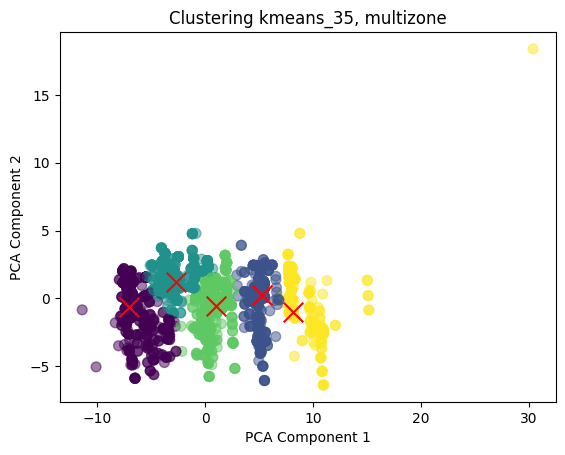

In [26]:
for model_name in models:
    for zone in models[model_name]:
        pca_plot(train_data[model_name][zone], models[model_name][zone], zone)

In [31]:
def apply_clustering_to_full_dataset(models: Dict[str, KMeans], dataset: pd.DataFrame) -> pd.DataFrame:
    for model_name in models:
        for zone in models[model_name]:
            print(f"Applying clustering to {model_name}/{zone}")
            for index, row in dataset.iterrows():
                print(f"\tProcessing row {index}/{len(dataset)}\t\t\t\t\t", end='\r')
                row_data = row[get_columns(celsius_a_fahrenheit(model_name_to_temp(model_name)))]
                if row_data.isnull().values.any():
                    continue
                cluster = models[model_name][zone].predict([row_data])
                dataset.at[index, model_name] = cluster[0]
        print("\tDataset processed\t\t\t\t\t\t\t\t\t\t")
    return dataset

In [32]:
# Ignore UserWarning
import warnings
warnings.filterwarnings("ignore")

clustered_dataset = apply_clustering_to_full_dataset(models, dataset)
    

Applying clustering to kmeans_-8/singlezone
Applying clustering to kmeans_-8/multizone
	Dataset processed														
Applying clustering to kmeans_8/singlezone
Applying clustering to kmeans_8/multizone
	Dataset processed														
Applying clustering to kmeans_28/singlezone
Applying clustering to kmeans_28/multizone
	Dataset processed														
Applying clustering to kmeans_35/singlezone
Applying clustering to kmeans_35/multizone
	Dataset processed														


In [33]:
# Print cluster value counts
for model_name in models:
    print(clustered_dataset[model_name].value_counts())

kmeans_-8
4.0    28722
1.0    10929
Name: count, dtype: int64
kmeans_8
4.0    39628
2.0       24
Name: count, dtype: int64
kmeans_28
2.0    762
Name: count, dtype: int64
kmeans_35
4.0    39491
Name: count, dtype: int64


In [35]:
# Print head of kmeans_-8 medoids
medoids["kmeans_-8"]["singlezone"].head()

,Status,Brand Name,Series Name,AHRI Certified Reference No.,Old AHRI Certified Reference No.,AHRI Type,Outdoor Unit Model,Indoor Unit Type,Indoor Model(s),Furnace Model Number (if applicable),...,Rated Input Power 82°F,Input Power at Max. Capacity 82°F,COP at Min. Capacity 82°F,COP at Rated Capacity 82°F,COP at Max. Capacity 82°F,Optional Low Temperature Data Outdoor Dry Bulb (°F),Optional Low Temperature Data Minimum Capacity X°F,Optional Low Temperature Data Maximum Capacity X°F,Optional Low Temperature Data Input Power at Min. Capacity X°F,Optional Low Temperature Data Input Power at Max. Capacity X°F
1538,Live,TRANE,NaN,NaN,207526554,HRCU-A-CB,4TWV8X36A1,NaN,4PX*CU42BS3,*DHMC100ACV4,...,NaN,2.43,9.20,NaN,4.49,NaN,NaN,NaN,NaN,NaN
9446,Live,BLUERIDGE,NaN,NaN,207339180,HRCU-A-CB-O,BMY18DIY22C,Mini-Splits,BMY18DIY22WM,NaN,...,NaN,1.15,5.20,NaN,4.88,NaN,NaN,NaN,NaN,NaN
10652,Live,Honeywell,NaN,NaN,207698174,HRCU-A-CB,HOH16S-60AA,NaN,HVTAN-36A,NaN,...,NaN,2.87,5.52,NaN,4.39,-5.0,12000.0,42000.0,0.8,3.63
32428,Live,AMERICAN STANDARD,NaN,NaN,201922755,HRCU-A-CB,4A6L9060A1,NaN,4PX*CU60BS3,*UHMC100ACV4,...,NaN,4.57,16.80,NaN,4.12,NaN,NaN,NaN,NaN,NaN
33564,Live,Bryant,Preferred,NaN,206900155,HRCU-A-CB,38MARBQ30AA3,NaN,CNPV*3621AL*,"8(0,1)*SA48070E21***",...,NaN,2.10,3.92,NaN,3.91,NaN,NaN,NaN,NaN,NaN
